<h1> This notebook is a guide through the MOQA approach and provides further intuition and functions to work with this framework

---

Background </h1>
All of the provided examples are based on QUBOs due to their broad applicabiluty, but cen be generalized to different Hamiltonians.

Thus for the numerical study a single objective function takes the form:

$ h(\mathbf{s}) = \mathbf{s}^\mathsf{t} \mathbf{A} \mathbf{s} + \mathbf{a}^\mathsf{t} \mathbf{s} + \alpha$,

mapping any binary vector $\mathbf{s} \in \left\{ \pm 1\right\}^n$ to it's cost $ h(\mathbf{s})$. We will interchangably use $\mathbf{s}$ and $\mathbf{b} \in \left\{0,1 \right\}^n$ because the first aligns with the implementation while the latter aligns with the article.

In [1]:
import numpy as np
from utils import generate_problem

base_seed = 10001
base_size = 6

A, a, alpha = generate_problem(size = base_size, seed=base_seed)
print("A = ", A)
print("a = ", a)
print("alpha = ", alpha)

A =  [[ 1.25218978  0.90468116 -0.7590274   0.21410369 -0.27402747 -0.57634923]
 [ 0.90468116 -0.66009438  0.21461406 -1.82029994 -0.56705973 -1.68517172]
 [-0.7590274   0.21461406  0.6353347  -0.07864951  0.27878092 -0.24502239]
 [ 0.21410369 -1.82029994 -0.07864951 -1.599556    0.30194709  0.37121439]
 [-0.27402747 -0.56705973  0.27878092  0.30194709  0.08550379 -0.05695097]
 [-0.57634923 -1.68517172 -0.24502239  0.37121439 -0.05695097  1.38295634]]
a =  [-0.05612432  0.15961356  0.31774754 -0.58333375 -1.21522318  0.48019494]
alpha =  -0.8900879060998703


`QUBO()` is a class for such problems with two methods (for verification) to convert them into the corresponding ising Hamiltonian.

The method `qubo_to_ising()` performs the transformation based on $H = \sum_{i,j=1}^n \left[\mathbf{A}\right]_{i,j} Z_i Z_j + \sum_{i=1}^n \left[\mathbf{a}\right]_i Z_i + \alpha I$. 
(Internally, this diagonal Hamiltonian is handeled as a vector)

In contrast, `qubo_to_ising_brute()` iterates over all possible $\mathbf{s}$ and stores the result in a vector.

In [2]:
from utils import QUBO

qubo = QUBO(A, a, alpha)

qubo.qubo_to_ising()
H1 = qubo.H

qubo.qubo_to_ising_brute()
H2 = qubo.H
np.allclose(H1, H2)

True

The ising hamiltonian is a diagonal matrix (or therefore just a vector) of dimension $2^n$ as visualized below. It is important to note that classically computing these $2^n$ is exponentially hard and serves here only to set the stage for the framework.

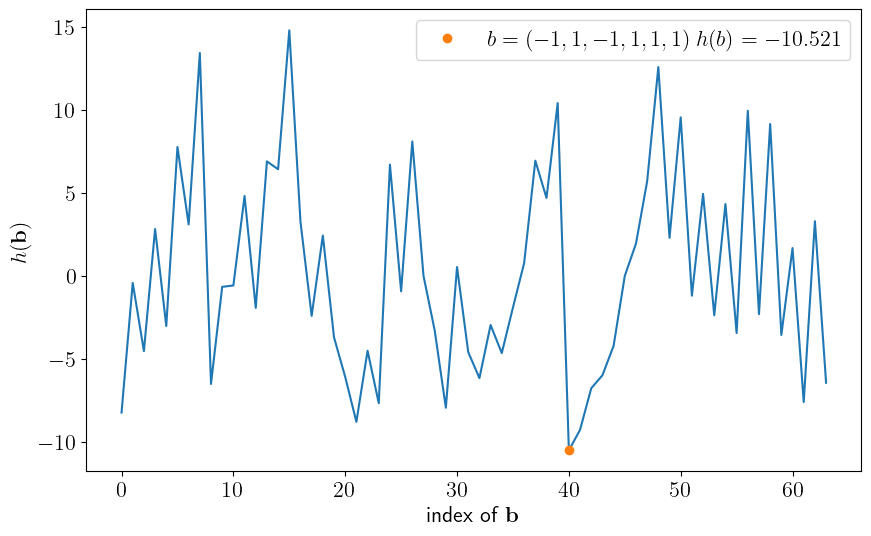

In [3]:
from utils import visualize_ising

visualize_ising(qubo)

<h2>M QUBOs</h2> 

---

Our main result is about working with a maximum over M such QUBOs

$h_{\max}(\mathbf{s})= \max \left\{ |h_1 (\mathbf{s})|,\ldots,|h_M (\mathbf{s})|\right\}$

For that, `M_QUBOs()` is the corresponding class, where each QUBO gets shifted by to ensure strictly positive objectives and get rid of the absolute value.

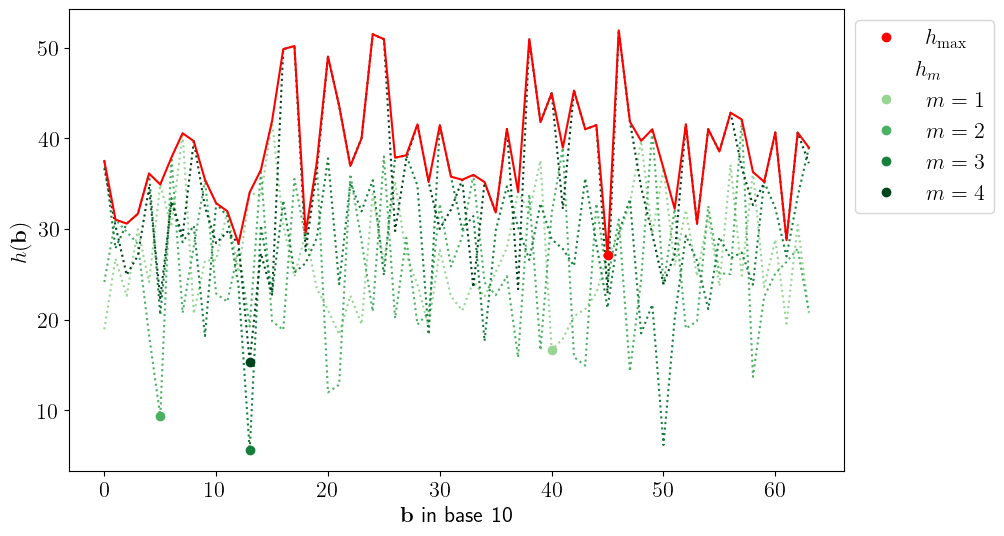

In [4]:
from utils import M_QUBOs, visualize_m_ising

M = 4
qubos_list = []

for i in range(M):
    A, a, alpha = generate_problem(size = base_size, seed=base_seed + i)
    qubo = QUBO(A, a, alpha)
    qubos_list.append(qubo)

m_qubos = M_QUBOs(qubos_list)
visualize_m_ising(m_qubos)

Now we approximate the max (infinity norm) with smaller p norms

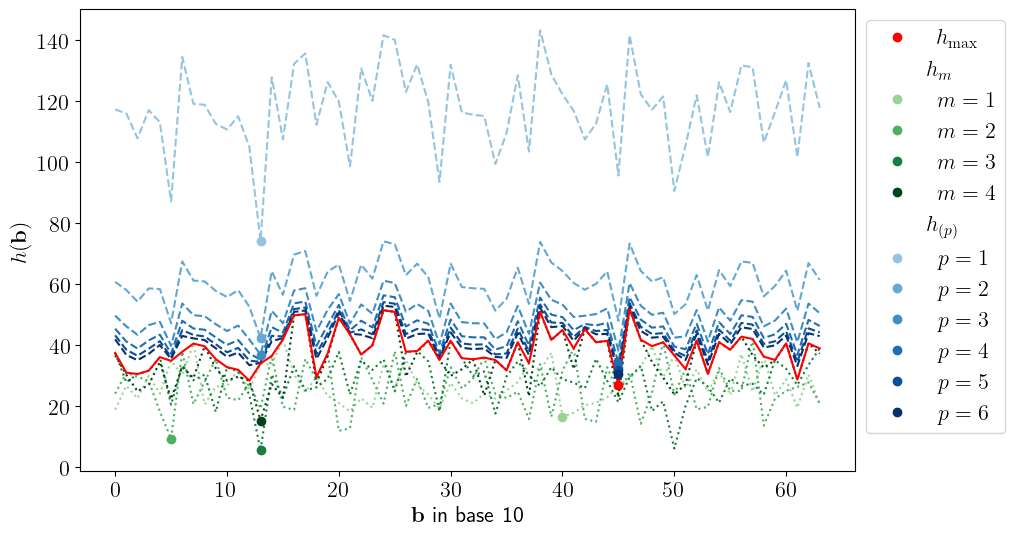

In [5]:
m_qubos.calculate_h_p(p_max=6)
visualize_m_ising(m_qubos, save_as="m_qubos_random")

<h2>Gates of QUBO+MOQA</h2> 

---

While numerically it is easy to take the p norm along some axis when we already have the ising Hamiltonian, this paves no way for quantum devises. For that, we need to find a way to describe $H_{(p)}$ with gates.
Thus, the following function `create_Cp()` takes in any list of QUBOs and outputs the corresponding Z-strings, which can be readily implemented on quantum devices.

In [6]:
from utils import create_Cp

p = 2
C_p = create_Cp(qubos_list, p)
for i, C in enumerate(C_p):
    print(f'bin({i}) = {format(i, f"0{base_size}b")}: {C}')

bin(0) = 000000: 3715.2591378313573
bin(1) = 000001: 9.532806111018331
bin(2) = 000010: -172.69110136802476
bin(3) = 000011: -246.86755813487213
bin(4) = 000100: -50.791671417476756
bin(5) = 000101: 90.79134437039662
bin(6) = 000110: 78.83665466544714
bin(7) = 000111: 3.9867553684247774
bin(8) = 001000: 21.138035782756432
bin(9) = 001001: 221.29026358727185
bin(10) = 001010: -163.73626129195856
bin(11) = 001011: -5.813640436685125
bin(12) = 001100: -173.23602429070255
bin(13) = 001101: -3.2588903749089404
bin(14) = 001110: -0.09198901601182641
bin(15) = 001111: 43.28412575911712
bin(16) = 010000: -56.1238227157078
bin(17) = 010001: 3.8021155844568995
bin(18) = 010010: -197.9949528928499
bin(19) = 010011: -10.398318959452657
bin(20) = 010100: 34.05982724488944
bin(21) = 010101: 5.983745548268607
bin(22) = 010110: -6.091758307321724
bin(23) = 010111: -20.173452400820196
bin(24) = 011000: 457.03246695316216
bin(25) = 011001: -12.171406466012561
bin(26) = 011010: -2.5103422944471063
bin(27

Sanity check by converting $C_p$ to $H_{(p)}$ via `convert_Cp_to_Hp`

In [7]:
from utils import convert_Cp_to_Hp

H_p_1 = convert_Cp_to_Hp(C_p)
H_p_2 = m_qubos._calculate_one_h_p(p)[0]**(p)
np.allclose(H_p_1, H_p_2)

True

<h2>Numerical Studies on M random QUBOs</h2> 

---

We can now create M random QUBOs and combine them with MOQA. Subsequently we analyze the minimum of $H_{(p)}$ compared to $H_{\max}$.

Running this many times using `run_random objectives.py` allows us to make statistics about the average $\delta$ and $\epsilon$ explained in the articles.

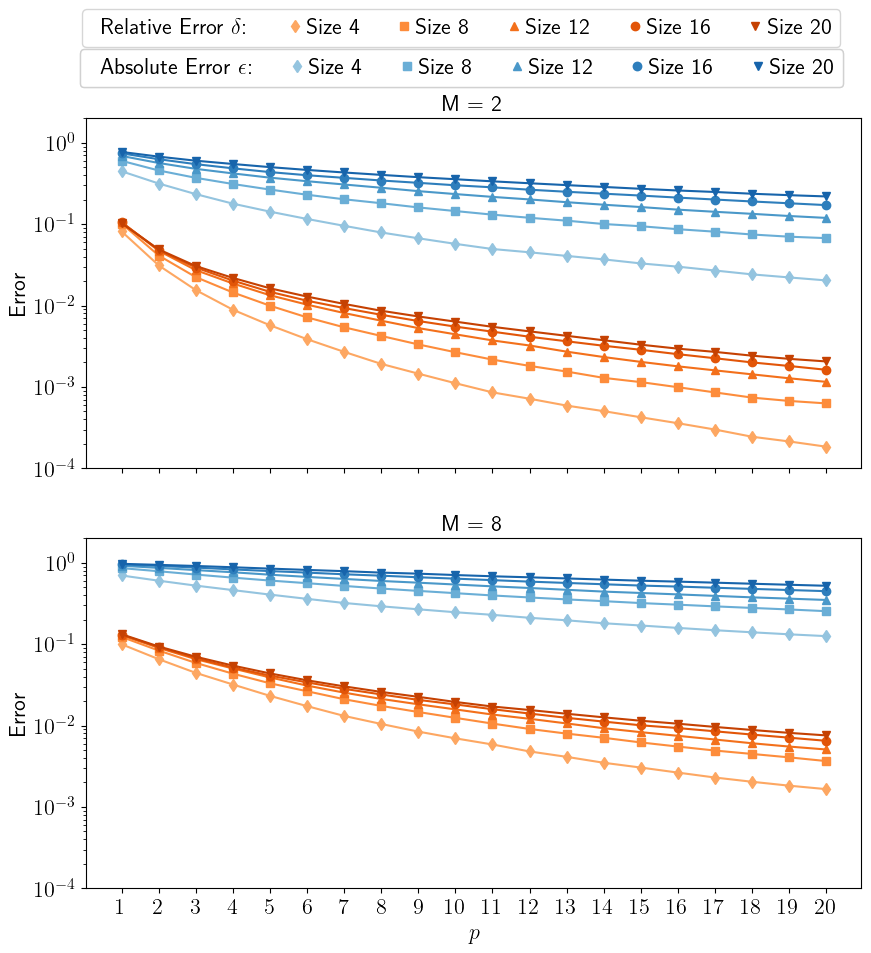

In [8]:
from utils import plot_performance_from_csv_multi

M_list=(2, 8)
plot_performance_from_csv_multi(
    csv_pattern="data/performance_random_M{M}.csv",
    M_list=M_list,
    output_path=f"figures/differences_random",
    ylim=(1e-4, 2),
    p_max = 20,
    fontsize=16
)

To support Theorem 1, we can purther put the spectral gap ratio on the x-axis

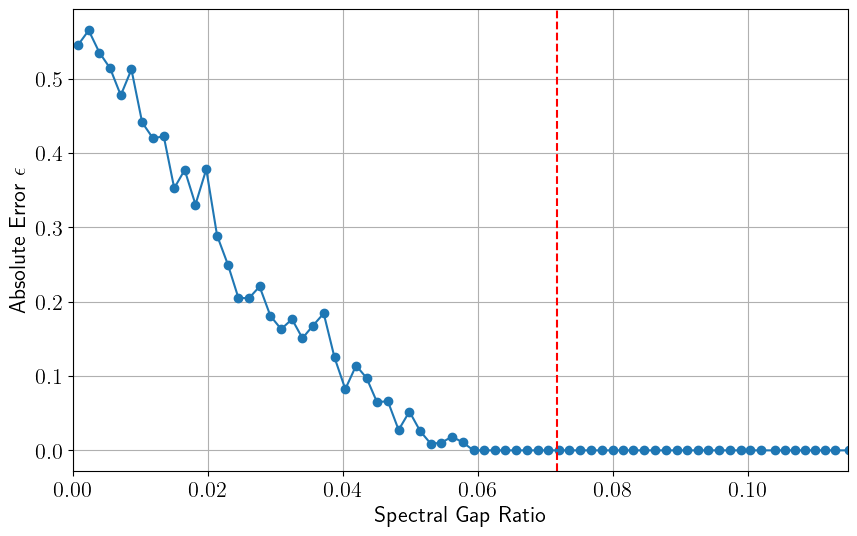

In [9]:
from utils import plot_thm1

p = 10
M = 2
size = 12
csv_path = "data/performance_random_M2.csv"
plot_thm1(csv_path, p, M, size = size, bins = 300, metric = 'wrong_idx', gap='ratio', save_as=f"figures/theorem1")

<h2> Numerical Studies on  Inequality Contraints </h2>

---

We will now turn to the first application: inequality constrains
Es explained in the manuscript, every $h(\mathbf{s})$ sunbect to $\mathbf{s}^t\mathbf{g}\geq\tau$ can be rewritten as $\max\{h(\mathbf{s}),h(\mathbf{s})-\gamma\mathbf{s}^t\mathbf{g}+\gamma\tau\}$.

This extends linearly to multiply constraints. `create_contrained_qubo()` takes in the original QUBO and constraints (created with `generate_constraint()`) and returns those `MQUBOs`.

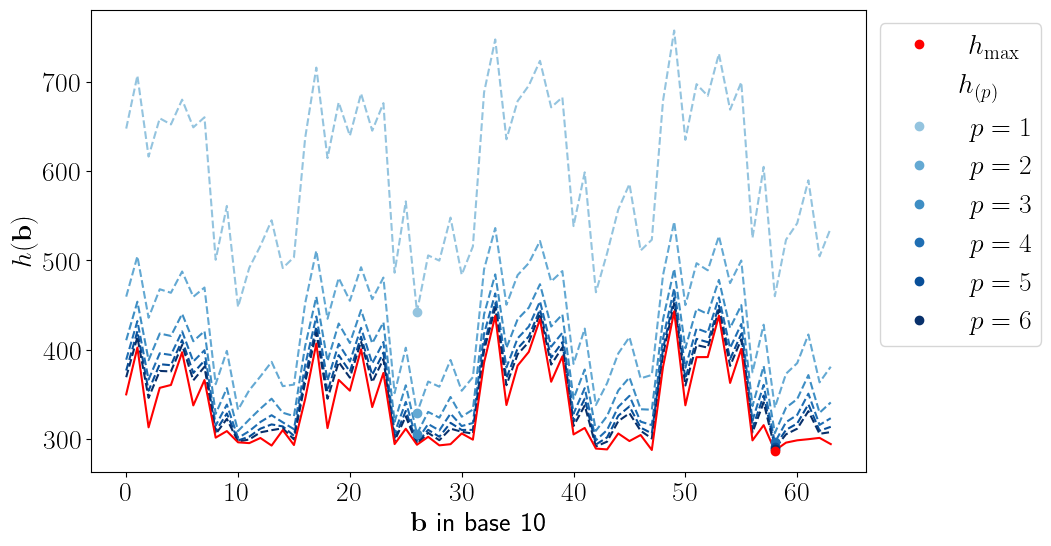

In [10]:
from utils import generate_constraint, create_contrained_qubo

gamma = 120
seed = base_seed+1

constraint = generate_constraint(size=base_size, gamma=gamma, tau_scale=0, seed=seed)
A, a, alpha = generate_problem(size = base_size, seed=seed)
qubo = QUBO(A, a, alpha)

m_qubos = create_contrained_qubo(qubo, [constraint])
m_qubos.calculate_h_p(p_max=6)
visualize_m_ising(m_qubos, show_part=False,show_original=False, save_as="m_qubos_constrained", fontsize=20)

The extra file `run_constrained_qubos.py` uses this routine to create data, which is analyzed like:

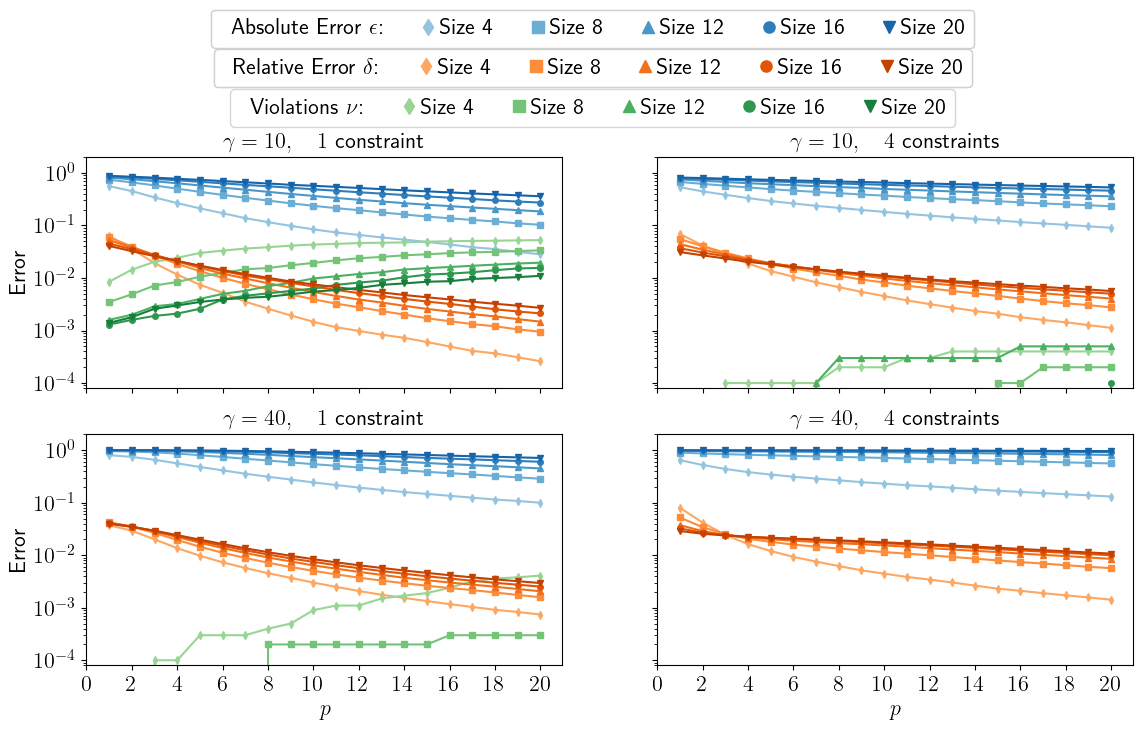

In [11]:
from utils import plot_grid_performance_constrained

plot_grid_performance_constrained(
     csv_path_template="data/performance_nconstr{nc}_tau{tau}_gamma{gamma}.csv",
     output_path="figures/differences_constrained",
     p_max=20,
     size_list=None,
     gammas=(10, 40),
     num_constraints_list=(1,4),
     tau=0,
     fontsize=16,
     ylim=(8*1e-5, 2),
     use_tex=True
 )

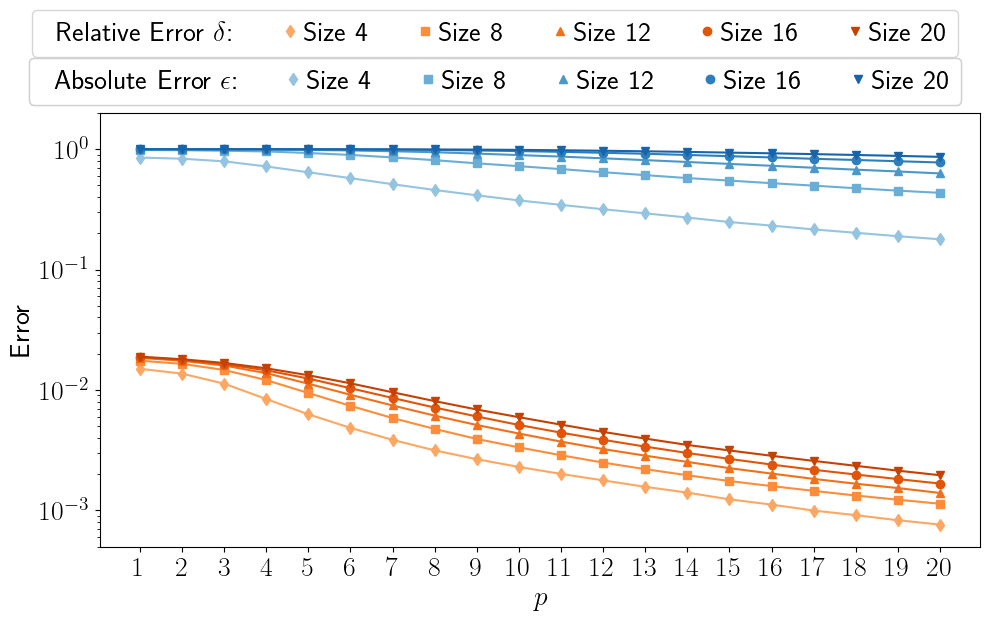

In [12]:
from utils import plot_performance_from_csv

plot_performance_from_csv(csv_path=f"data/performance_nconstr1_tau0_gamma120.csv", output_path=f"figures/differences_one_constr", ylim=(5*1e-4, 2),p_max = 20, fontsize=20, legend_1_anchor=(0.5,0.97), legend_2_anchor=(0.5,1.05))

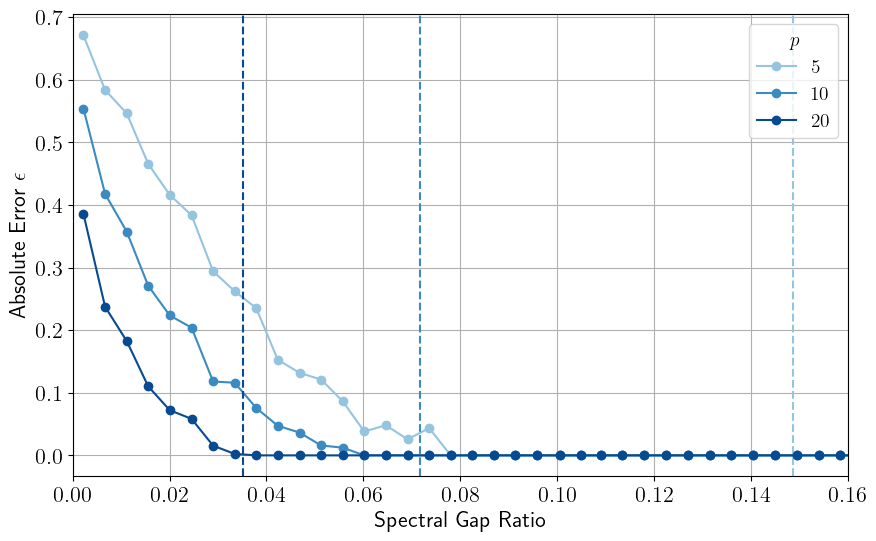

In [13]:
from utils import plot_thm1_multi

p_list = [5,10,20]
M = 2
size = 16
csv_path = "data/performance_nconstr1_tau0_gamma6.csv"

plot_thm1_multi(csv_path, p_list, M, size = size, bins = 100, metric = 'wrong_idx', gap ='ratio', save_as=f"figures/theorem1_multi", x_lim = (0,0.16))

<h2> Numerics for the Partitioning Problem </h2>

---

We will now turn to the second application: partitioning problems
For this application, we first create random $\mathbf{W}$ and $\mathbf{v}$ and consequently try to minimize:

$h_{\max}(\mathbf{s})= \max \left\{ |\mathbf{s}^\mathsf{t} \mathbf{A} \mathbf{s} + \mathbf{a}^\mathsf{t} \mathbf{s} + \alpha|,|\mathbf{s}^\mathsf{t} \mathbf{A} \mathbf{s} - \mathbf{a}^\mathsf{t} \mathbf{s} + \alpha|\right\}$

with $\mathbf{A} = \mathbf{W}/4$, $\mathbf{a} = \left(\mathbf{W}\mathbf{1} + \mathbf{v}\right)/2$ and $\alpha = \left(\mathbf{1}^\mathsf{t}\mathbf{W}\mathbf{1} + 2\mathbf{1}^\mathsf{t}\mathbf{v}\right)/4$

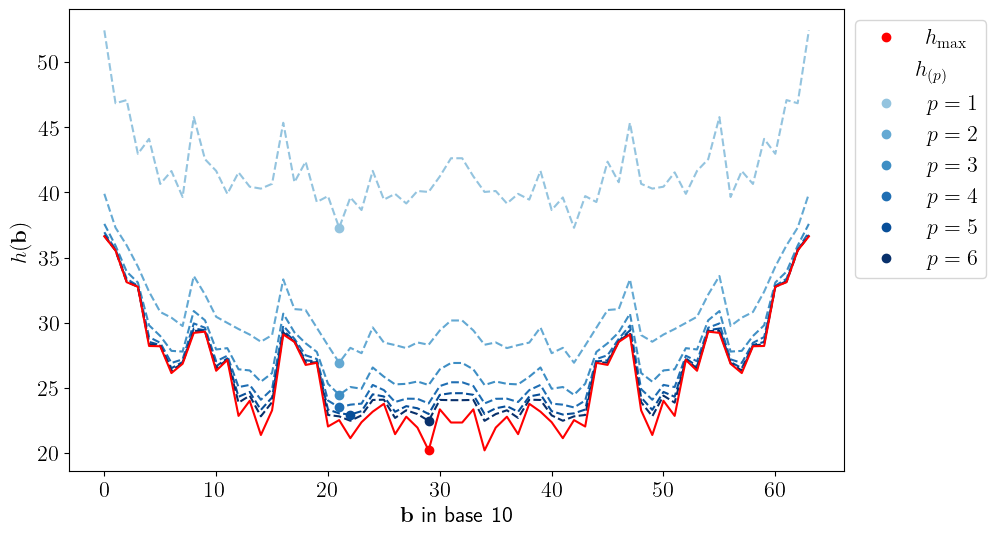

In [14]:
from utils import generate_random_graph, generate_distance_matrix, create_t_pm

seed = base_seed+3
points, vertices = generate_random_graph(n=base_size, mode='gaussian', seed=seed)
W, v = generate_distance_matrix(points, vertices=vertices)
A, a, alpha = create_t_pm(W, v)

q_list = [QUBO(A, a, alpha), QUBO(A, -a, alpha)]
m_qubos = M_QUBOs(q_list)
m_qubos.calculate_h_p(p_max=6)

visualize_m_ising(m_qubos, save_as="m_qubos_partition", tpm=True, show_original=False)

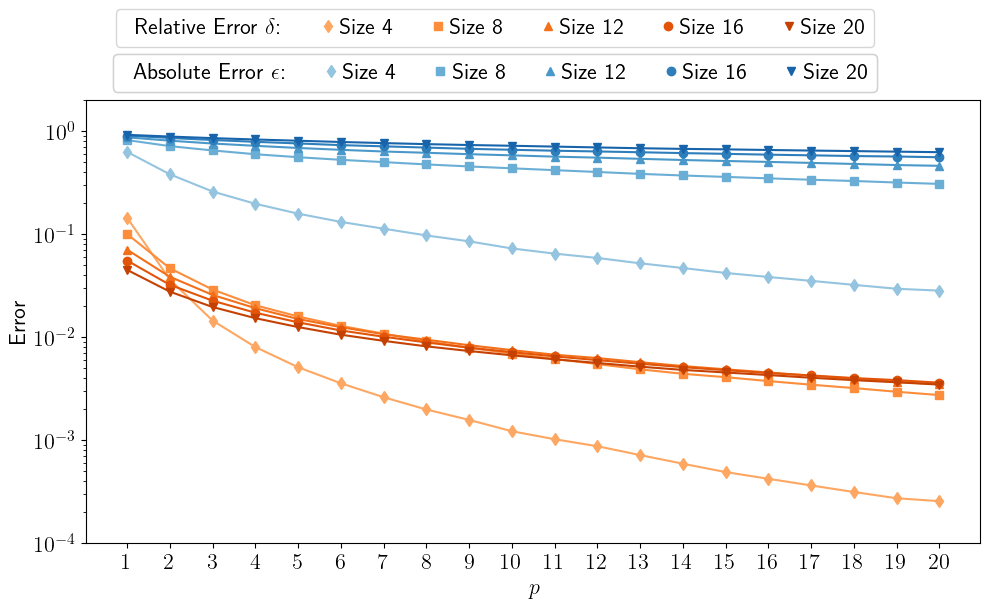

In [15]:
from utils import plot_performance_from_csv

mode = 'gaussian'
plot_performance_from_csv(csv_path=f"data/performance_partitions_{mode}.csv", output_path=f"figures/differences_partitions", ylim=(1e-4, 2),p_max = 20)